In [80]:
from sklearn.base import BaseEstimator

class Bayes(BaseEstimator):

    def __init__(self, alpha=1, lambdas=[1, 1], ngram_cnt=1):
        self.p = 25013
        self.k = len(lambdas)
        self.ngram_cnt = ngram_cnt
        self.alpha = alpha
        self.lambdas = lambdas
        self.n = 0
        self.all_ngrams=None
        self.logn = None
        self.ps = None
        self.messages_count = None
        self.word_count = None
        self.rev_prob = None
        self.prob = None

    def fit(self, xs, ys):
        self.n = len(xs)
        self.k = len(self.lambdas)
        self.all_ngrams = set()
        self.ps = [self.p ** i for i in range(0, self.ngram_cnt)]
        self.messages_count = np.zeros(self.k, dtype=int)
        self.word_count = np.array([{} for _ in range(self.k)])
        self.rev_prob = np.array([{} for _ in range(self.k)])
        self.prob = np.array([{} for _ in range(self.k)])

        for i in range(self.n):
            words, c = xs[i], int(ys[i])
            w_len = len(words)
            self.messages_count[c] += 1
            wc = self.word_count[c]
            ngram_cnt = min(self.ngram_cnt, w_len)
            ngram = 0
            cur_ngram = set()
            for j in range(ngram_cnt - 1):
                ngram += words[j] * self.ps[j]
            for j in range(ngram_cnt - 1, w_len):
                ngram += words[j] * self.ps[ngram_cnt - 1]
                if ngram not in cur_ngram:
                    wc[ngram] = wc.get(ngram, 0) + 1
                    cur_ngram.add(ngram)
                    self.all_ngrams.add(ngram)
                ngram -= words[j - ngram_cnt + 1]
                ngram /= self.p

        for c in range(self.k):
            wc = self.word_count[c]
            div = self.messages_count[c] + 2 * self.alpha
            class_prob = self.prob[c]
            class_rev_prob = self.rev_prob[c]
            for word in self.all_ngrams:
                class_prob[word] = (wc.get(word, 0) + self.alpha) / div
                class_rev_prob[word] = 1 - class_prob[word]

    def predict_msg(self, xs):
        ngrams = set()
        w_len = len(xs)
        ngram_cnt = min(self.ngram_cnt, w_len)
        ngram = 0
        for j in range(ngram_cnt - 1):
            ngram += xs[j] * self.ps[j]
        for j in range(ngram_cnt - 1, w_len):
            ngram += xs[j] * self.ps[ngram_cnt - 1]
            ngrams.add(ngram)
            ngram -= xs[j - ngram_cnt + 1]
            ngram /= self.p

        anss = [self.lambdas[c] * self.messages_count[c] / self.n for c in range(self.k)]
        for c in range(self.k):
            if self.messages_count[c] == 0:
                continue
            for word in self.all_ngrams:
                if word in ngrams:
                    anss[c] *= self.prob[c].get(word, 1)
                else:
                    anss[c] *= self.rev_prob[c].get(word, 1)

        s = sum(anss)
        if s == 0:
            return 0
        anss = list(map(lambda x: x / s, anss))
        return anss.index(max(anss))

    def predict(self, xs):
        return np.array(list(map(self.predict_msg, xs)))

In [81]:
from os import listdir
import numpy as np

def read_file(ind, filename):
    with open("part{}/{}".format(ind, filename), "r") as file:
        x = np.array(list(map(int, file.read().split()[1:])))
        y = 1 if "spmsg" in filename else 0
        return x, y, max(x)

def read_part(ind):
    files = listdir("part{}".format(ind))
    mx = -1
    xs, ys = [], []
    for filename in files:
        x, y, mx_x = read_file(ind, filename)
        mx = max(mx, mx_x)
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype=object), np.array(ys), mx

def read_all():
    mx = -1
    xs, ys = [], []
    for ind in range(0, 10):
        x, y, mx_x = read_part(ind + 1)
        mx = max(mx, mx_x)
        xs.extend(x)
        ys.extend(y)
    print("Max word: {}".format(mx))
    return np.array(xs, dtype=object), np.array(ys)

In [82]:
mx = -1
xs, ys = read_all()

Max word: 24747


In [83]:
from sklearn.model_selection import GridSearchCV

params = {
    "alpha": [10 ** i for i in range(-7, 5)],
    "ngram_cnt": list(range(1, 4))
}
best_acc = GridSearchCV(Bayes(), params, cv=10, n_jobs=-1, scoring="accuracy", verbose=5)
best_acc.fit(xs, ys)

print("Best acc score: {}".format(best_acc.best_score_))
print("On params: {}".format(best_acc.best_params_))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 35.3min finished


Best acc score: 0.8082568807339451
On params: {'alpha': 1e-06, 'ngram_cnt': 1}


10/10

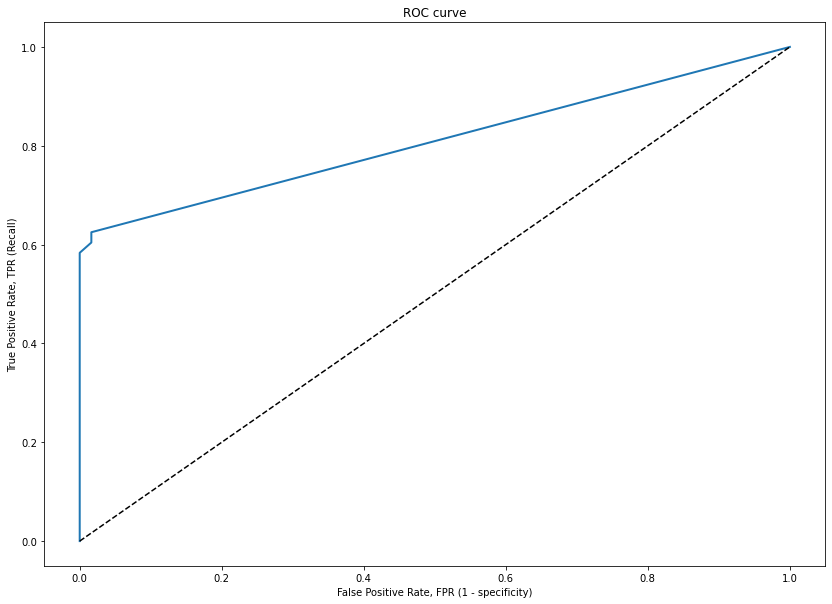

In [84]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

best_params = best_acc.best_params_
alpha, ngram_cnt = best_params["alpha"], best_params["ngram_cnt"]

bayes = Bayes(alpha=alpha, ngram_cnt=ngram_cnt)
folder = KFold(10, shuffle=False)
tpr, fpr = [0, 1], [0, 1]

cur = 0
for train_ind, test_ind in folder.split(xs):
    cur += 1
    print("\r{}/{}".format(cur, 10), end='')
    cm = [[0, 0], [0, 0]]
    train_xs, train_ys = xs[train_ind], ys[train_ind]
    test_xs, test_ys = xs[test_ind], ys[test_ind]
    bayes.fit(train_xs, train_ys)
    pred = bayes.predict(test_xs)
    for i in range(len(pred)):
        cm[test_ys[i]][pred[i]] += 1
    tpr.append(cm[1][1] / (cm[1][1] + cm[1][0]))
    fpr.append(cm[0][1] / (cm[0][1] + cm[0][0]))

tpr.sort()
fpr.sort()

plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate, FPR (1 - specificity)")
plt.ylabel("True Positive Rate, TPR (Recall)")
plt.title("ROC curve")
plt.show()

In [85]:
from sklearn.metrics import accuracy_score

def score_spam(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f_spam = sum([y_true[i] == 0 and y_pred[i] == 1 for i in range(len(y_true))])
    return acc - 100 * f_spam

In [86]:
from sklearn.metrics import make_scorer

params = {
    "alpha": [10 ** i for i in range(-7, 5)],
    "lambdas": [[10 ** i, 1] for i in range(0, 30)]
}
lambda_search = GridSearchCV(Bayes(), params, cv=10, n_jobs=-1, scoring=make_scorer(score_spam), verbose=5)
lambda_search.fit(xs, ys)

print("Best score: {}".format(lambda_search.best_score_))
print("On params: {}".format(lambda_search.best_params_))

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 55.9min finished


Best score: 0.8027522935779817
On params: {'alpha': 1e-06, 'lambdas': [10000, 1]}


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.5min finished


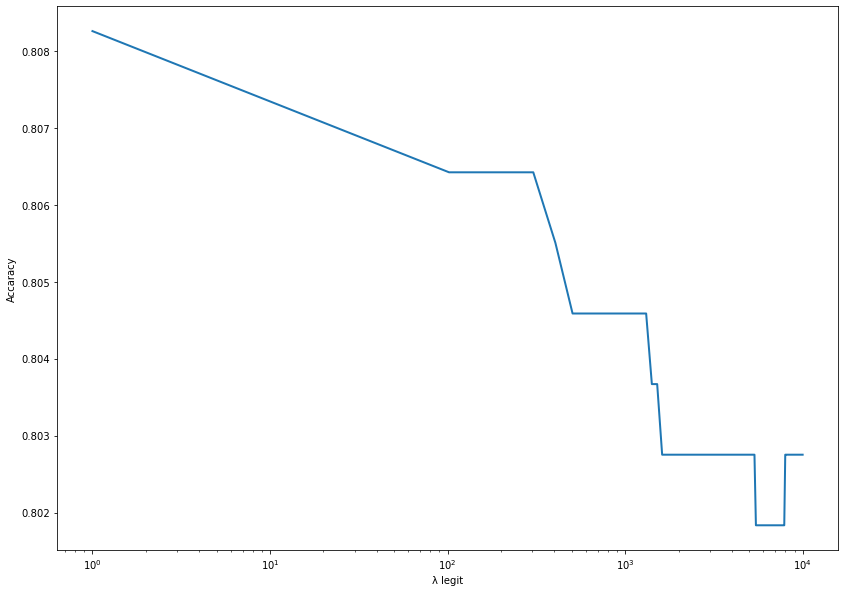

In [87]:
best_params = lambda_search.best_params_
max_lambdas = best_params["lambdas"][0]
params = {
    "lambdas": [[i, 1] for i in np.linspace(1, max_lambdas, 100)]
}
lambda_stats = GridSearchCV(Bayes(alpha=best_params["alpha"]), params, cv=10, n_jobs=-1, scoring="accuracy", verbose=5)
lambda_stats.fit(xs, ys)

lambdas_ = [i for i in np.linspace(1, max_lambdas, 100)]
accuracy_ = lambda_stats.cv_results_["mean_test_score"]
plt.figure(figsize=(14, 10))
plt.semilogx(lambdas_, accuracy_, linewidth=2)
plt.xlabel('λ legit')
plt.ylabel('Accaracy')
plt.show()